In [ ]:
"""
@authors: faurand, chardes, ehagensieker
"""
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import tqdm
import pprint

In [ ]:
# add an empty dimension and scale the images to values between 0 and 1
normalize = lambda x: tf.cast(tf.expand_dims(x, -1), tf.float32) / 255.

# add noise to the image   
add_noise = lambda x, e: tf.clip_by_value(x + e * tf.random.normal(mean=0., stddev=1., shape=x.shape),
                                          clip_value_min=0.,
                                          clip_value_max=1.)

def prepare_data(ds, noise_level=0.4, batch_size=32):
    # apply lambda functions
    ds = ds.map(lambda x,t: (normalize(x), normalize(t)))
    ds = ds.map(lambda x,t: (add_noise(x, noise_level), t))
    
    # shuffle, batch, prefetch
    ds = ds.cache().shuffle(1028).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return ds

def plot_images(ds, img_size=(28,28)):
    fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(22,5))

    for noisy_images, original_images in ds.take(1):
        for i in range(10): 
            ax[0,i].imshow(noisy_images[i].numpy().reshape(img_size))
            ax[0,i].set(title='noisy image')
            ax[1,i].imshow(original_images[i].numpy().reshape(img_size))
            ax[1,i].set(title='original image')

    plt.show();

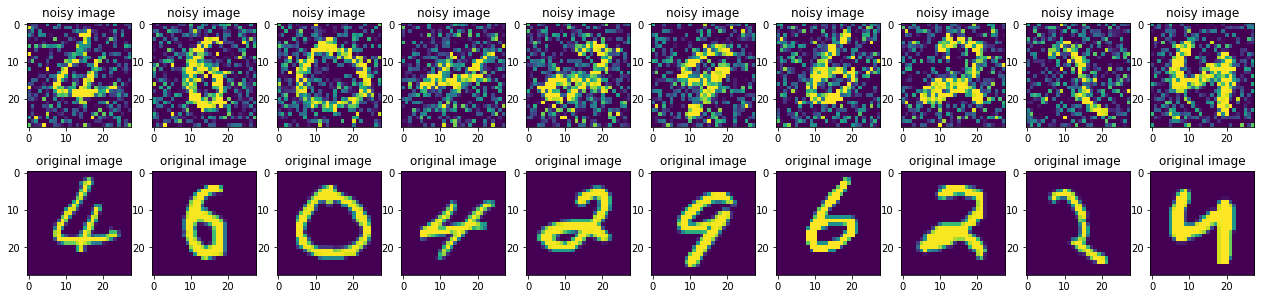

In [ ]:
# load the dataset
(X_train,_), (X_test,_) = tf.keras.datasets.mnist.load_data()

# set the originial images as targets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, X_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, X_test))

# prepare the dataset
train_ds = prepare_data(train_ds)
test_ds = prepare_data(test_ds)

# plot the noisy images and the original target images
plot_images(train_ds)

In [ ]:
from keras.layers import Conv2D, Dense, Flatten, BatchNormalization, Dropout

class Encoder(tf.keras.layers.Layer):

    def __init__(self, latent_dim):
        super(Encoder, self).__init__()

        self.layer_list =  [tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding = 'same', activation = 'relu'),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding = 'same', activation = 'relu'),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Dense(latent_dim, activation='relu')]

    def call(self, x , training=False):
        for layer in self.layer_list:
            x = layer(x)
        return x

In [ ]:
from tensorflow.keras.layers import Conv2DTranspose

class Decoder(tf.keras.Model):

    def __init__(self):
        super(Decoder, self).__init__()

        self.layer_list =  [tf.keras.layers.Dense(3136, activation='relu'),
                            tf.keras.layers.Reshape((7,7,64)),
                            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.Conv2D(1, kernel_size=(3, 3), padding='same', activation='sigmoid')]

    def call(self, x , training=False):
        for layer in self.layer_list:
            x = layer(x)
        return x

In [ ]:
class Autoencoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()

        self.metrics_list = [tf.keras.metrics.Mean(name="loss"),
                             tf.keras.metrics.Accuracy(name="acc")]

        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder()

    def call(self, x, training=False):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded       

    @property
    def metrics(self):
        return self.metrics_list

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()

    @tf.function 
    def train_step(self, data):
        x, t = data
        
        with tf.GradientTape() as tape:
            output = self(x, training = True)
            loss = self.compiled_loss(t, output, regularization_losses=self.losses)
        
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.metrics[0].update_state(loss)
        self.metrics[1].update_state(t, output)

        return {m.name : m.result() for m in self.metrics}

    @tf.function
    def test_step(self, data):
        x, t = data
        
        output = self(x, training=False)
        loss = self.compiled_loss(t, output, regularization_losses=self.losses)
                
        self.metrics[0].update_state(loss)
        self.metrics[1].update_state(t, output)
        
        return {m.name : m.result() for m in self.metrics}

In [ ]:
model = Autoencoder(10)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.MeanSquaredError()

# compile the model
model.compile(optimizer=optimizer, loss=loss)

In [ ]:
EXPERIMENT_NAME = "denoising_autoencoder"
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logging_callback = tf.keras.callbacks.TensorBoard(log_dir=f"./logs/{EXPERIMENT_NAME}/{current_time}")

In [ ]:
history = model.fit(train_ds,
                    validation_data=test_ds,
                    initial_epoch=0,
                    epochs=10,
                    callbacks=[logging_callback])

Epoch 1/10
1875/1875 [==============================] - 27s 10ms/step - loss: 0.0326 - acc: 2.6127e-05 - val_loss: 0.0225 - val_acc: 0.0000e+00
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0228 - acc: 6.3776e-08 - val_loss: 0.0209 - val_acc: 1.2755e-07
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0217 - acc: 4.2517e-08 - val_loss: 0.0202 - val_acc: 0.0000e+00
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0210 - acc: 2.1259e-08 - val_loss: 0.0190 - val_acc: 0.0000e+00
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0206 - acc: 2.1259e-08 - val_loss: 0.0184 - val_acc: 0.0000e+00
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0202 - acc: 4.2517e-08 - val_loss: 0.0184 - val_acc: 0.0000e+00
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0200 - acc: 0.0000e+00 - val_loss: 0.0181 - val_acc: 1.2755e-0

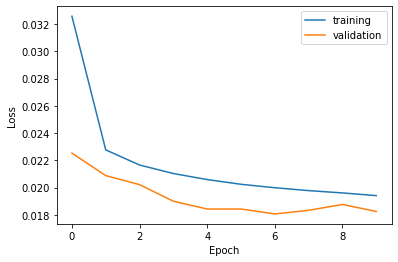

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
#plt.plot(history.history["acc"])
#plt.plot(history.history["val_acc"])
plt.legend(labels=["training","validation"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()